# Lab 3 — Geometric Transformations (Manual & Built-in)

This notebook performs the following steps on the Lena image (grayscale):

1. Read `Lena.png` and convert to grayscale.
2. Implement geometric transformations manually (without built-in transform functions) using inverse-mapping + bilinear interpolation:
   - Translation
   - Scaling
   - Rotation (about image center)
   - Shearing in X-direction
   - Shearing in Y-direction
3. Repeat the same transforms using OpenCV built-ins (`cv2.warpAffine`) and compare results (display + MSE).

Use the manual implementations to observe correctness and differences between custom and built-in implementations.

MSE between manual and OpenCV results:
Translation: MSE = 0.0000
Scaling: MSE = 0.4186
Rotation: MSE = 20.5373
Shear X: MSE = 2.7747
Shear Y: MSE = 4.9007


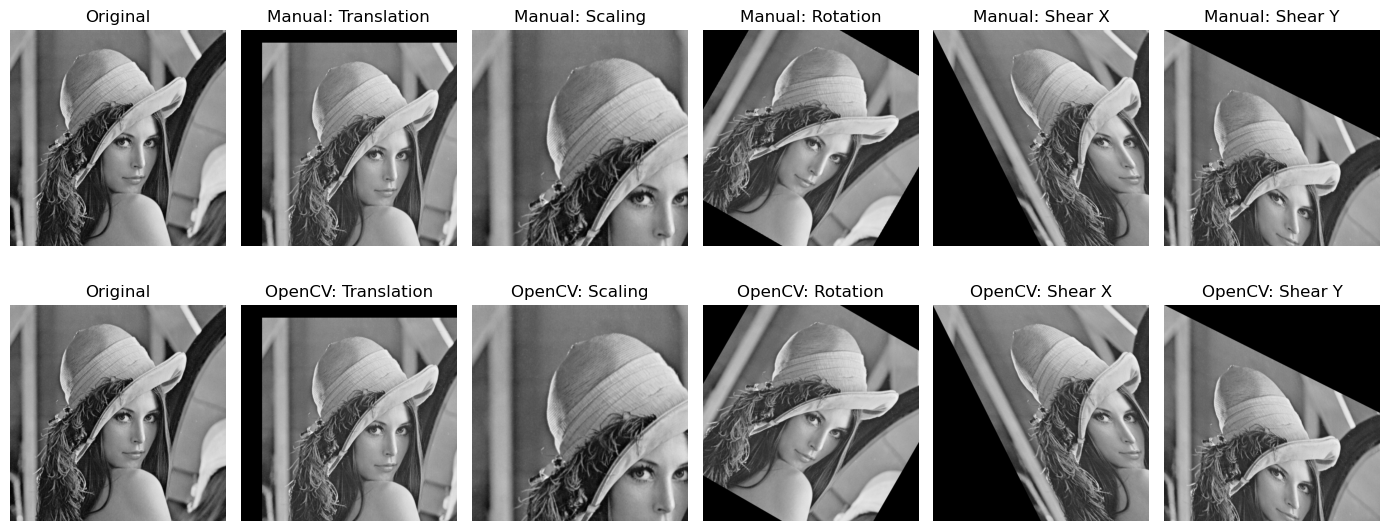

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read Lena.png and convert to grayscale
img = cv2.imread('Lena.png', cv2.IMREAD_COLOR)
if img is None:
    raise FileNotFoundError("Lena.png not found in this folder. Place Lena.png next to this notebook.")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Helper: bilinear sampling for arrays of coordinates (vectorized)
def bilinear_sample(img, xs, ys):
    h, w = img.shape
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    x0 = np.floor(xs).astype(int)
    y0 = np.floor(ys).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1

    x0c = np.clip(x0, 0, w - 1)
    x1c = np.clip(x1, 0, w - 1)
    y0c = np.clip(y0, 0, h - 1)
    y1c = np.clip(y1, 0, h - 1)

    Ia = img[y0c, x0c]
    Ib = img[y0c, x1c]
    Ic = img[y1c, x0c]
    Id = img[y1c, x1c]

    wa = (x1 - xs) * (y1 - ys)
    wb = (xs - x0) * (y1 - ys)
    wc = (x1 - xs) * (ys - y0)
    wd = (xs - x0) * (ys - y0)

    # For coordinates outside original bounds, we should zero weights where coords are outside
    outside = (xs < 0) | (xs > (w - 1)) | (ys < 0) | (ys > (h - 1))
    wa[outside] = 0
    wb[outside] = 0
    wc[outside] = 0
    wd[outside] = 0

    result = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return result.astype(np.uint8)

# Apply an affine transform using inverse mapping + bilinear interpolation
# M is 2x3 (numpy array), out_shape is (h_out, w_out)
def apply_affine_manual(img, M, out_shape=None):
    h, w = img.shape
    if out_shape is None:
        out_h, out_w = h, w
    else:
        out_h, out_w = out_shape

    # Create 3x3 matrix
    H = np.array([[M[0,0], M[0,1], M[0,2]],
                  [M[1,0], M[1,1], M[1,2]],
                  [0.0,     0.0,     1.0]])

    Hinv = np.linalg.inv(H)

    # grid of destination coordinates
    xv, yv = np.meshgrid(np.arange(out_w), np.arange(out_h))
    coords = np.stack([xv.ravel(), yv.ravel(), np.ones(out_w * out_h)])
    src_coords = Hinv @ coords
    xs = src_coords[0, :]
    ys = src_coords[1, :]

    sampled = bilinear_sample(img, xs, ys)
    return sampled.reshape((out_h, out_w))

# Define transforms
h, w = gray.shape
cx, cy = (w - 1) / 2.0, (h - 1) / 2.0

# 1. Translation
tx, ty = 50, 30
M_trans = np.array([[1.0, 0.0, tx], [0.0, 1.0, ty]])

# 2. Scaling (about origin)
sx, sy = 1.5, 1.5
M_scale = np.array([[sx, 0.0, 0.0], [0.0, sy, 0.0]])

# 3. Rotation about image center by angle degrees
angle = 30  # degrees
theta = np.deg2rad(angle)
cos_t = np.cos(theta)
sin_t = np.sin(theta)
# Translate center to origin, rotate, translate back: M = T(c) * R * T(-c)
T1 = np.array([[1.0, 0.0, -cx], [0.0, 1.0, -cy], [0.0, 0.0, 1.0]])
R = np.array([[cos_t, -sin_t, 0.0], [sin_t, cos_t, 0.0], [0.0, 0.0, 1.0]])
T2 = np.array([[1.0, 0.0, cx], [0.0, 1.0, cy], [0.0, 0.0, 1.0]])
M_rot_3x3 = T2 @ R @ T1
M_rot = M_rot_3x3[:2, :]

# 4. Shear X
shx = 0.5
M_shear_x = np.array([[1.0, shx, 0.0], [0.0, 1.0, 0.0]])

# 5. Shear Y
shy = 0.5
M_shear_y = np.array([[1.0, 0.0, 0.0], [shy, 1.0, 0.0]])

transforms = [
    ("Translation", M_trans),
    ("Scaling", M_scale),
    ("Rotation", M_rot),
    ("Shear X", M_shear_x),
    ("Shear Y", M_shear_y),
]

# Apply manual transforms
manual_results = []
for name, M in transforms:
    out = apply_affine_manual(gray, M, out_shape=(h, w))
    manual_results.append((name, out, M))

# Apply built-in transforms using cv2.warpAffine
builtin_results = []
for name, M in transforms:
    # cv2.warpAffine expects float32 matrix
    out_cv = cv2.warpAffine(gray, M.astype(np.float32), (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    builtin_results.append((name, out_cv, M))

# Display results
n = len(transforms)
plt.figure(figsize=(14, 6))
plt.subplot(2, n + 1, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.axis('off')

for i, (name, out, M) in enumerate(manual_results, start=2):
    plt.subplot(2, n + 1, i)
    plt.imshow(out, cmap='gray')
    plt.title(f"Manual: {name}")
    plt.axis('off')

plt.subplot(2, n + 1, n + 2)
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.axis('off')

for i, (name, out, M) in enumerate(builtin_results, start=n + 3):
    plt.subplot(2, n + 1, i)
    plt.imshow(out, cmap='gray')
    plt.title(f"OpenCV: {name}")
    plt.axis('off')

plt.tight_layout()

# Compute MSE between manual and built-in outputs
print("MSE between manual and OpenCV results:")
for (name_m, out_m, M_m), (name_b, out_b, M_b) in zip(manual_results, builtin_results):
    mse = np.mean((out_m.astype(np.float32) - out_b.astype(np.float32))**2)
    print(f"{name_m}: MSE = {mse:.4f}")
